In [184]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[4]").appName("MPC").getOrCreate()
sc = spark.sparkContext

In [424]:
n = 20
m = 15
max_weight = 10

import networkx as nx
from random import randrange

# create a random graph
vertices = range(n)
edges = [(randrange(n), randrange(n), randrange(max_weight)) for _ in range(m)]

def save_graph(G, filename='graph.txt'):
    # persist to file
    nx.write_adjlist(G, file)

def load_graph(filename='graph.txt'):
    # read from file
    return nx.read_adjlist(filename)

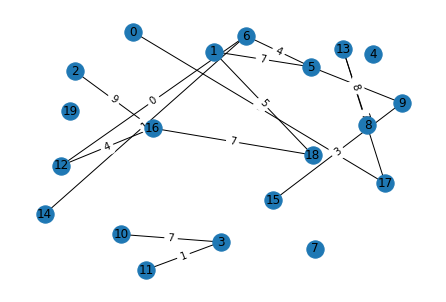

In [425]:
G = nx.Graph() # empty graph
G.add_nodes_from(vertices)
G.add_weighted_edges_from(edges)

# uses a force-directed simulation, better for large graphs
pos = nx.spring_layout(G, k=1, iterations=10)

# positions the nodes deterministically in ccw order, which is pretty nice for toy graphs
#pos = nx.shell_layout(G)

labels = nx.get_edge_attributes(G, 'weight')

nx.draw(G, pos, with_labels=True);
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

In [426]:
# access the adjaceny list of G
for n in G:
    print(str(n) + ": " + str(G[n]))

0: {17: {'weight': 1}}
1: {5: {'weight': 7}, 18: {'weight': 5}}
2: {16: {'weight': 9}}
3: {10: {'weight': 7}, 11: {'weight': 1}}
4: {}
5: {6: {'weight': 4}, 1: {'weight': 7}, 9: {'weight': 5}}
6: {14: {'weight': 1}, 5: {'weight': 4}, 12: {'weight': 0}}
7: {}
8: {13: {'weight': 8}}
9: {5: {'weight': 5}, 15: {'weight': 3}}
10: {3: {'weight': 7}}
11: {3: {'weight': 1}}
12: {16: {'weight': 4}, 6: {'weight': 0}}
13: {17: {'weight': 7}, 8: {'weight': 8}}
14: {6: {'weight': 1}}
15: {9: {'weight': 3}}
16: {12: {'weight': 4}, 2: {'weight': 9}, 18: {'weight': 7}}
17: {13: {'weight': 7}, 0: {'weight': 1}}
18: {1: {'weight': 5}, 16: {'weight': 7}}
19: {}


In [427]:
def nearest_neighbor(adj_item):
    """Compute the nearest neighbor, if it exists, based on weights."""
    
    # TODO: can this be done more elegantly?
    node = adj_item[0]
    ngbs = adj_item[1]
    
    if len(ngbs) == 0:
        return node, node
    else:
        nn = min(ngbs, key=lambda x: ngbs[x]['weight'])
        return node, nn

In [428]:
def contract_map(nn_br):
    # get the broadcasted value
    nn = nn_br.value

    def inner(adj_item):

        # TODO: can this be done more elegantly?
        u = adj_item[0]
        ngbs = adj_item[1]

        c = u
        v = u
        S = set()
        while v not in S:
            S.add(v)
            c = v
            v = nn[v]

        label = min(c, v)

        return label, (u, ngbs)

    return inner

In [429]:
# create a rdd for the adjancency list
adj = sc.parallelize(G.adj.items())

In [430]:
# compute the nearest_neighbor mapping
nn_local = dict(adj.map(nearest_neighbor).collect())

# broadcast the closest neighbor mapping
nn = sc.broadcast(nn_local)

In [440]:
nn.value

{0: 17,
 1: 18,
 2: 16,
 3: 11,
 4: 4,
 5: 6,
 6: 12,
 7: 7,
 8: 13,
 9: 15,
 10: 3,
 11: 3,
 12: 6,
 13: 17,
 14: 6,
 15: 9,
 16: 12,
 17: 0,
 18: 1,
 19: 19}

In [432]:
labeling = adj.map(contract_map(nn))

In [433]:
labeling.collect()

[(0, (0, AtlasView({17: {'weight': 1}}))),
 (1, (1, AtlasView({5: {'weight': 7}, 18: {'weight': 5}}))),
 (6, (2, AtlasView({16: {'weight': 9}}))),
 (3, (3, AtlasView({10: {'weight': 7}, 11: {'weight': 1}}))),
 (4, (4, AtlasView({}))),
 (6, (5, AtlasView({6: {'weight': 4}, 1: {'weight': 7}, 9: {'weight': 5}}))),
 (6, (6, AtlasView({14: {'weight': 1}, 5: {'weight': 4}, 12: {'weight': 0}}))),
 (7, (7, AtlasView({}))),
 (0, (8, AtlasView({13: {'weight': 8}}))),
 (9, (9, AtlasView({5: {'weight': 5}, 15: {'weight': 3}}))),
 (3, (10, AtlasView({3: {'weight': 7}}))),
 (3, (11, AtlasView({3: {'weight': 1}}))),
 (6, (12, AtlasView({16: {'weight': 4}, 6: {'weight': 0}}))),
 (0, (13, AtlasView({17: {'weight': 7}, 8: {'weight': 8}}))),
 (6, (14, AtlasView({6: {'weight': 1}}))),
 (9, (15, AtlasView({9: {'weight': 3}}))),
 (6,
  (16, AtlasView({12: {'weight': 4}, 2: {'weight': 9}, 18: {'weight': 7}}))),
 (0, (17, AtlasView({13: {'weight': 7}, 0: {'weight': 1}}))),
 (1, (18, AtlasView({1: {'weight': 5

In [434]:
M = labeling.map(lambda z: (z[0], z[1][0])).groupByKey()

def label_vertices(z):
    label = z[0]
    vertices = z[1]
    return [(v, label) for v in vertices]

L_local = dict(M.flatMap(label_vertices).collect())
L = sc.broadcast(L_local)
L.value

{0: 0,
 8: 0,
 13: 0,
 17: 0,
 4: 4,
 1: 1,
 18: 1,
 9: 9,
 15: 9,
 2: 6,
 5: 6,
 6: 6,
 12: 6,
 14: 6,
 16: 6,
 3: 3,
 10: 3,
 11: 3,
 7: 7,
 19: 19}

In [435]:
N = labeling.map(lambda z: (z[0], set(z[1][1].keys())))
N.collect()

[(0, {17}),
 (1, {5, 18}),
 (6, {16}),
 (3, {10, 11}),
 (4, set()),
 (6, {1, 6, 9}),
 (6, {5, 12, 14}),
 (7, set()),
 (0, {13}),
 (9, {5, 15}),
 (3, {3}),
 (3, {3}),
 (6, {6, 16}),
 (0, {8, 17}),
 (6, {6}),
 (9, {9}),
 (6, {2, 12, 18}),
 (0, {0, 13}),
 (1, {1, 16}),
 (19, set())]

In [436]:
def combiner(x, y):
    x.update(y)
    return x

def merger(x, y):
    return x.union(y)

# combine neighbor sets
N0 = N.aggregateByKey(set(), combiner, merger)
N0.collect()

[(0, {0, 8, 13, 17}),
 (4, set()),
 (1, {1, 5, 16, 18}),
 (9, {5, 9, 15}),
 (6, {1, 2, 5, 6, 9, 12, 14, 16, 18}),
 (3, {3, 10, 11}),
 (7, set()),
 (19, set())]

In [437]:
# translate to labels
N1 = N0.map(lambda x: (x[0], { L.value[x] for x in x[1] }))
N1.collect()

[(0, {0}),
 (4, set()),
 (1, {1, 6}),
 (9, {6, 9}),
 (6, {1, 6, 9}),
 (3, {3}),
 (7, set()),
 (19, set())]

In [438]:
N2 = N1.map(lambda x: (x[0], x[1].difference({x[0]})))
N2.collect()

[(0, set()),
 (4, set()),
 (1, {6}),
 (9, {6}),
 (6, {1, 9}),
 (3, set()),
 (7, set()),
 (19, set())]